In [21]:
# 元ファイルはなし（このページにおいて記載）

In [1]:
import pandas as pd

path = "/disks/qnap2/notebook/t-nakamura/research_lastfm/data/listening_events_20050214_20200320_fin.pkl"
df = pd.read_pickle(path)

In [4]:
# df_country_dict = {"United States" : df[df["country"]=="United States"],\
#                    "United Kingdom" : df[df["country"]=="United Kingdom"],\
#                    "Brazil" : df[df["country"]=="Brazil"],\
#                    "Russia" : df[df["country"]=="Russia"]}

## ジャンルごとのGini、広がり具合の分析

In [3]:
df_2019 = df.query("year == 2019")#.sample(1000000)

In [5]:
# rock, popを削除し、次に有力なジャンルを抽出
def mod_top_tag (tags_dict):
    sorted_dict = dict(sorted(tags_dict.items(), key=lambda item: item[1], reverse=True))
    sorted_key_list = list(sorted_dict.keys())
    cleaned_key_list = [v for v in sorted_key_list if v not in ["rock", "pop"]]
    if len(cleaned_key_list) == 0:
        return sorted_key_list[0]
    else:
        return cleaned_key_list[0]

df_2019["mod_top_tag"] = df_2019["tags"].apply(lambda x: mod_top_tag(x))

/tmp/ipykernel_2208645/4060748732.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019["mod_top_tag"] = df_2019["tags"].apply(lambda x: mod_top_tag(x))


In [6]:
df_genre_ranking = df_2019["top_tag"].value_counts(ascending=False).to_frame()
df_reset = df_genre_ranking.reset_index()
df_reset.columns = ['genre', 'count']  # カラム名をわかりやすく

# これで df_reset は
#   genre    count
# 0 pop      3689908
# 1 rock     3474566
# ...
# 34 k-pop   261238

# k-pop の行を取得
k_pop_index = df_reset.query("genre == 'k-pop'").index[0]

# k_pop_index の前後10件の「genre」だけを取りたいとき
# loc[] の第1引数にスライス、 第2引数にカラムを指定
target_genres = df_reset.loc[k_pop_index - 10 : k_pop_index + 10, 'genre'].tolist()

In [7]:
print("=== df_genre_ranking.index の先頭50件 ===")
print(df_genre_ranking.index[:50])

print("=== df_genre_ranking.reset_index() の先頭数行 ===")
print(df_genre_ranking.reset_index().head())

# k-pop (小文字ハイフン) で完全一致しているか
df_test = df_genre_ranking.reset_index()
df_test.columns = ['genre', 'count']  # わかりやすいように列名を付け直す
print("=== k-pop を含むかどうか ===")
print(df_test.loc[df_test['genre'] == 'k-pop'])

# 大文字小文字・前後の空白を取り除いて比較
df_test['genre_clean'] = df_test['genre'].str.lower().str.strip()
print(df_test.loc[df_test['genre_clean'] == 'k-pop'])

=== df_genre_ranking.index の先頭50件 ===
Index(['rock', 'pop', 'indie_rock', 'classic_rock', 'metal', 'folk', 'ambient',
       'alternative_rock', 'rap', 'hard_rock', 'punk', 'progressive_metal',
       'hip_hop', 'soundtrack', 'soul', 'black_metal', 'jazz',
       'progressive_rock', 'indie_pop', 'metalcore', 'experimental',
       'new_wave', 'melodic_death_metal', 'thrash_metal', 'death_metal',
       'power_metal', 'singer-songwriter', 'industrial', 'industrial_metal',
       'electronica', 'synthpop', 'post-rock', 'downtempo', 'post-punk',
       'country', 'grunge', 'doom_metal', 'house', 'post-hardcore',
       'symphonic_metal', 'shoegaze', 'k-pop', 'funk', 'electropop',
       'gothic_metal', 'nu_metal', 'hardcore', 'emo', 'dream_pop', 'reggae'],
      dtype='object')
=== df_genre_ranking.reset_index() の先頭数行 ===
          index  top_tag
0          rock  5736673
1           pop  5717719
2    indie_rock  1909584
3  classic_rock  1568475
4         metal  1493042
=== k-pop を含むかどうか =

In [9]:
target_genres += ["k-pop", "djent", "new_rave", "trap", "j-pop", "chillwave"]

In [10]:
df_2019_target_genres = df_2019.query("top_tag in @target_genres")

In [11]:
def gini2(y):
    y.sort()
    n = len(y)
    nume = 0
    for i in range(n):
        nume = nume + (i+1)*y[i]
        
    deno = n*sum(y)
    return ((2*nume)/deno - (n+1)/(n))*(n/(n-1))


nuser_2019 = df_2019["user_id"].nunique()
df_target_genre = df_2019_target_genres[["top_tag", "user_id", "year", "track_id"]]
df_target_genre_user_year_count = df_target_genre[["top_tag", "user_id", "year"]].groupby(["top_tag", "year"]).nunique()
df_target_genre_user_year_count["user_ratio"] = df_target_genre_user_year_count["user_id"] / nuser_2019

df_target_genre_user_listen_count = df_target_genre[["top_tag", "year", "user_id", "track_id"]].groupby(["top_tag", "year", "user_id"]).count()
unstack_ = df_target_genre_user_listen_count.unstack(level=["user_id"])

df_gini_ = unstack_.apply(lambda x: gini2([v for v in x if pd.notnull(v)]) if len([v for v in x if pd.notnull(v)]) >= 2 else 0, axis = 1).to_frame()
df_gini_.columns = ["gini"]
df_gini_user_ratio = pd.merge(df_gini_, df_target_genre_user_year_count[["user_ratio"]], how= "left", left_index = True, right_index = True)

In [12]:
df_kpop = df_2019.query("top_tag == 'k-pop'")
df_kpop_user_count = df_kpop[["country", "user_id", "year"]].groupby(["country", "year"]).nunique()
df_kpop_user_listen_count = df_kpop[["country", "year", "user_id", "track_id"]].groupby(["country", "year", "user_id"]).count()
df_kpop_user_listen_count_country = df_kpop[["country", "year", "track_id"]].groupby(["country", "year"]).count()

In [13]:
df_country_user_count = df[["country", "user_id", "year"]].groupby(["country", "year"]).nunique()

In [14]:
df_country_year_merge = pd.merge(df_kpop_user_count, df_country_user_count, how = "left", left_index = True, right_index = True)
df_country_year_merge.columns = ["kpop_user_count", "total_user_count"]
df_country_year_merge["kpop_user_ratio"] = df_country_year_merge["kpop_user_count"] / df_country_year_merge["total_user_count"]

In [15]:
unstack_ = df_kpop_user_listen_count.unstack(level=["user_id"])
df_gini_ = unstack_.apply(lambda x: gini2([v for v in x if pd.notnull(v)]) if len([v for v in x if pd.notnull(v)]) >= 2 else 0, axis = 1).to_frame()
df_gini_.columns = ["gini"]
df_gini_kpop_ratio =  pd.merge(df_gini_, df_country_year_merge["kpop_user_ratio"], how = "left", left_index= True  , right_index = True)

## 読み込む時はここから

In [ ]:
#df_gini_user_ratio.to_pickle("./pickle_data/df_gini_user_ratio.pkl")
#df_genre_ranking.to_pickle("./pickle_data/df_genre_ranking.pkl")
#df_gini_kpop_ratio.to_pickle("./pickle_data/df_gini_kpop_ratio.pkl")
#df_kpop_user_listen_count_country.to_pickle("./pickle_data/df_kpop_user_listen_count_country.pkl")

In [17]:
kpop_countries = [
    "United States", "United Kingdom", "Indonesia", "Japan",
    "Finland", "Russia", "Brazil", "Germany", "Poland", "United_States", "United_Kingdom"
]

In [20]:
target_genres = ['post-rock',
 'downtempo',
 'post-punk',
 'country',
 'grunge',
 'doom_metal',
 'house',
 'post-hardcore',
 'symphonic_metal',
 'shoegaze',
 'k-pop',
 'funk',
 'electropop',
 'gothic_metal',
 'nu_metal',
 'hardcore',
 'emo',
 'dream_pop',
 'reggae',
 'disco',
 'alternative_metal',
 'k-pop',
 'djent',
 'new_rave',
 'trap',
 'j-pop',
 'chillwave']

In [25]:
import pandas as pd

# 保存されたpickleファイルを読み込む
df_gini_user_ratio = pd.read_pickle("./pickle_data/df_gini_user_ratio.pkl")
df_genre_ranking = pd.read_pickle("./pickle_data/df_genre_ranking.pkl")
df_gini_kpop_ratio = pd.read_pickle("./pickle_data/df_gini_kpop_ratio.pkl")
df_kpop_user_listen_count_country = pd.read_pickle("./pickle_data/df_kpop_user_listen_count_country.pkl")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


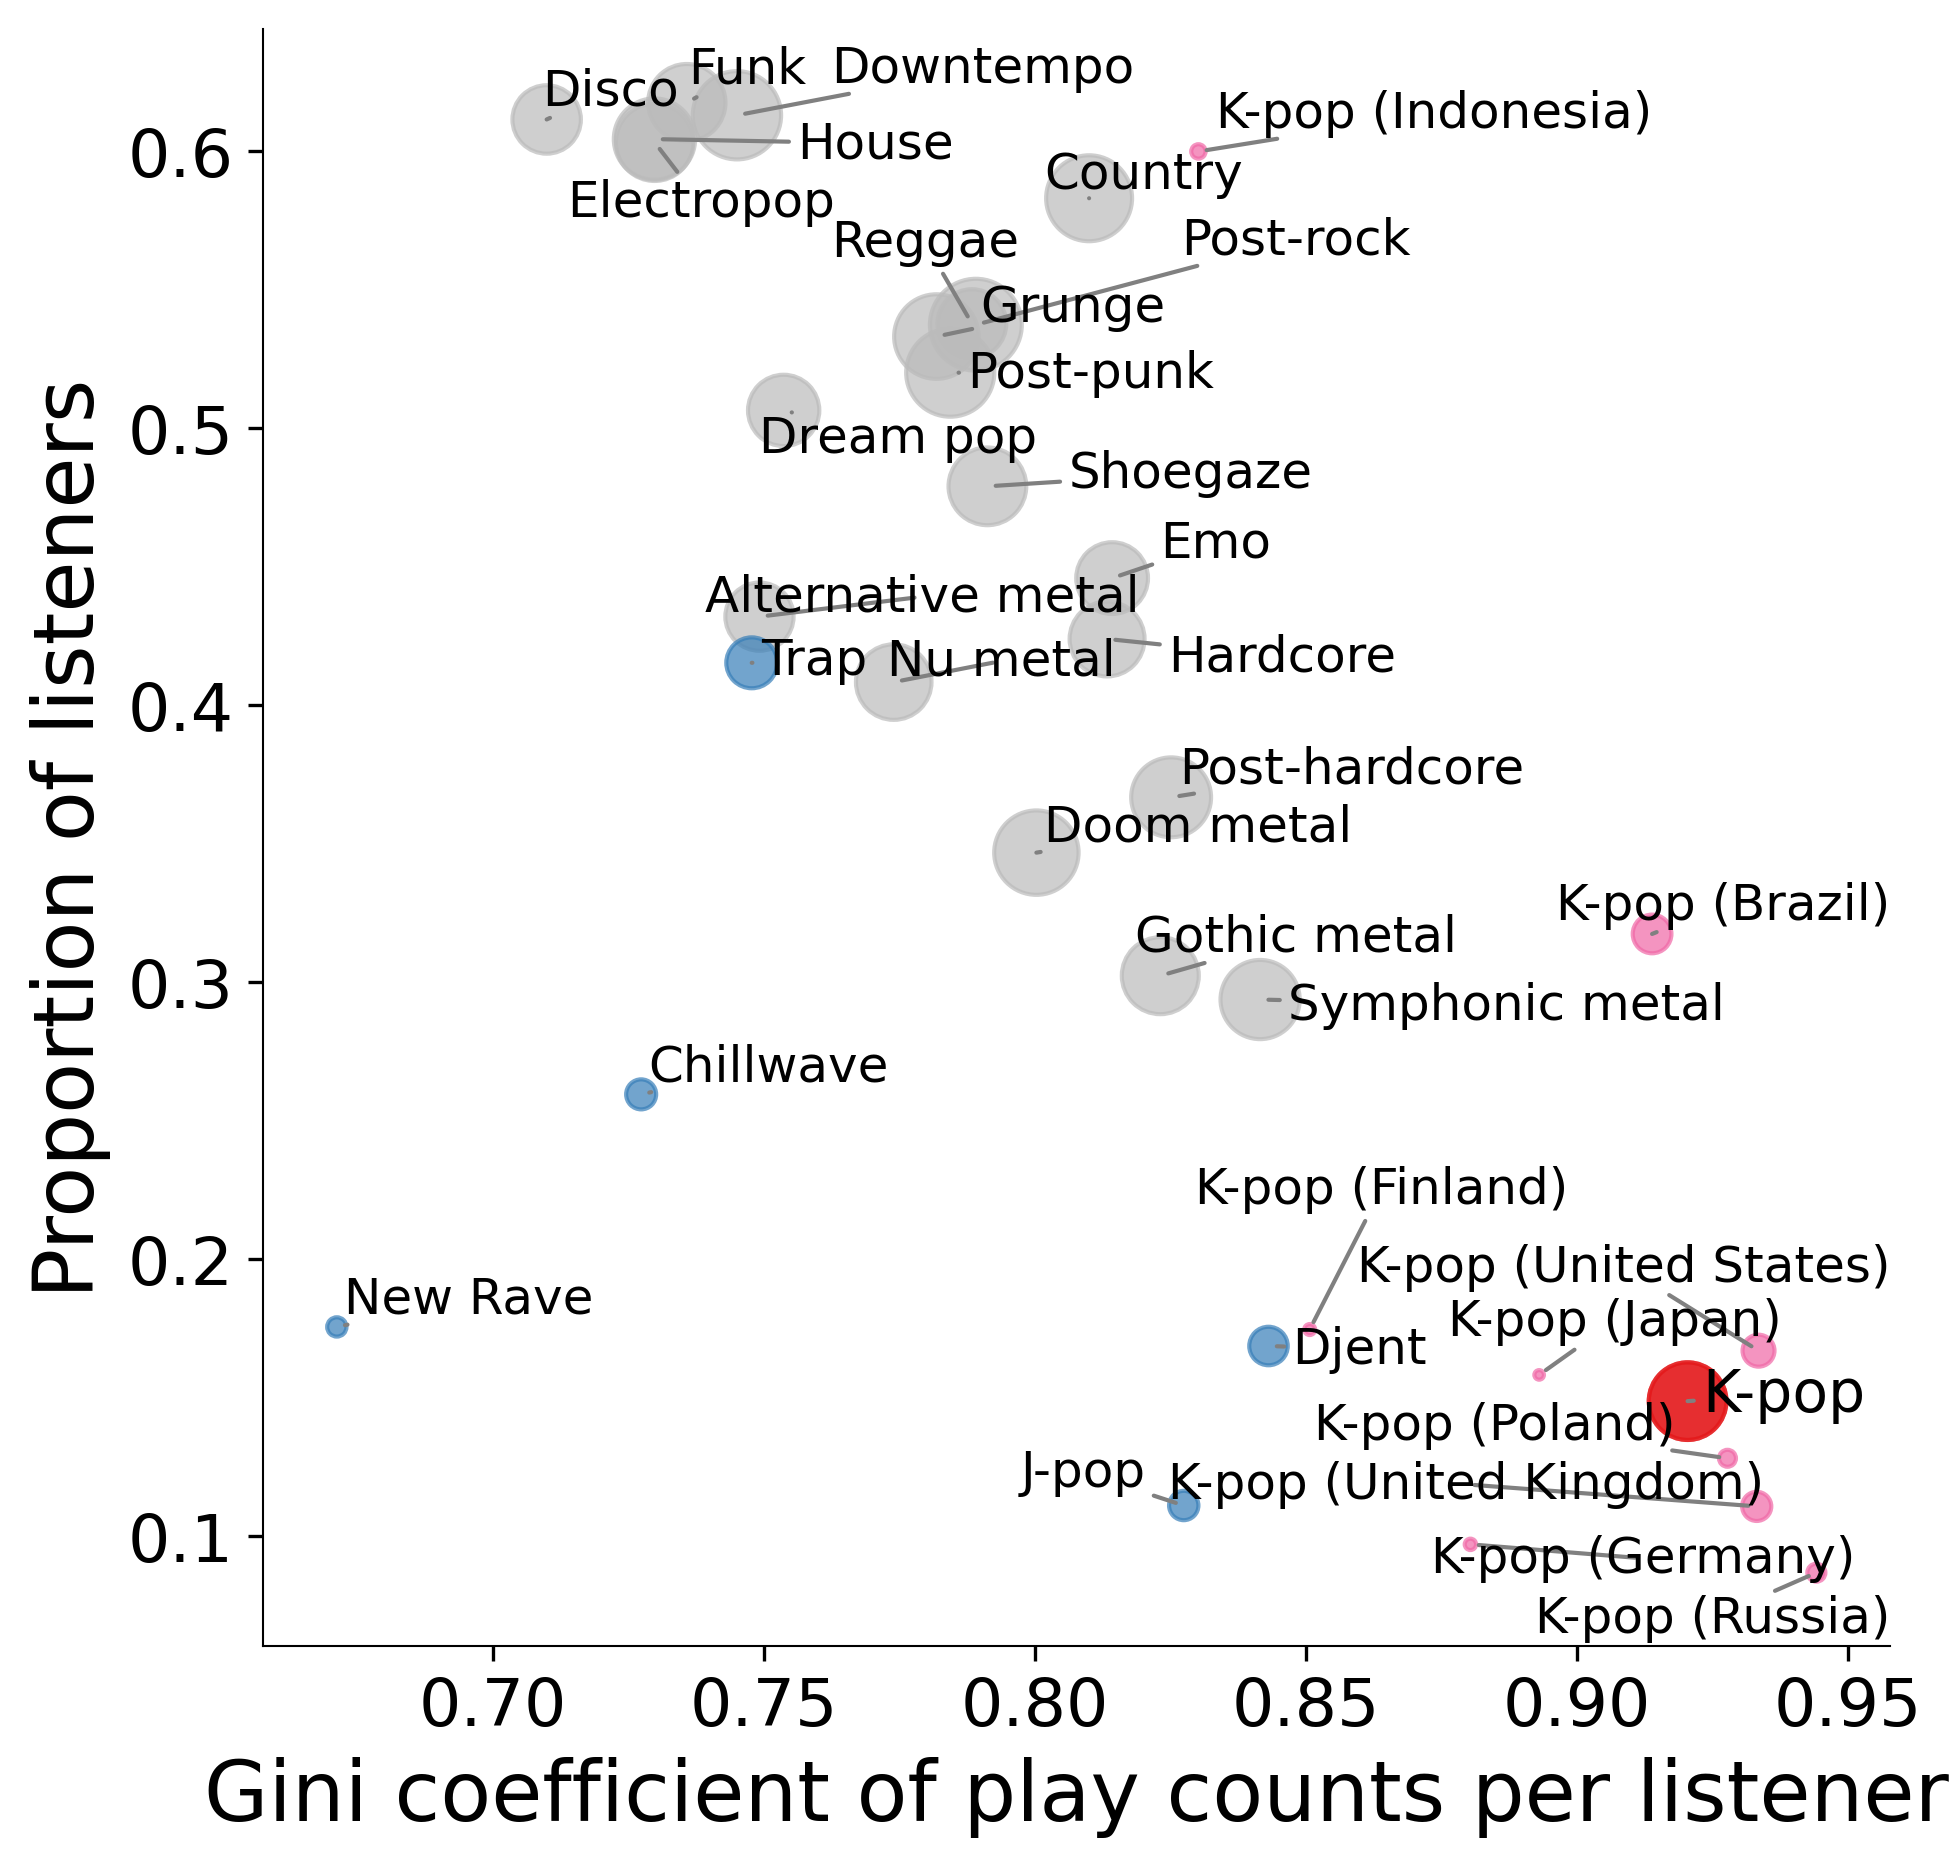

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from adjustText import adjust_text

# -------------------------------------------------------
# カラーマップ定義（既存コード）
# -------------------------------------------------------
tag_color_map = {
    "k-pop": "#e41a1c",
    "korean_pop": "#b22222",
    "j-pop": "#377eb8",
    'pop': '#2ca02c',
    "rock": "#d62728",
    "rap": "#bcbd22",
    "other": "#aaaaaa",
    "anime": "#66c2a5",
    "j-rock": "#8da0cb",
    "soundtrack": "#a6d854",
    "visual_kei": "#ffd92f",
    "boy_band": "#f46d43",
    "girl_group": "#e78ac3",
    'Ambient': '#a6cee3',
    'Pop': '#2ca02c',
    'Punk': '#fdbf6f',
    'Rock': '#d4a6c8',
    'rock': '#d4a6c8',
    'Progressive Metal': '#ffff99',
    'Metalcore': '#b2df8a',
    'Indie Rock': '#fb9a99',
    'Black Metal': '#1f78b4',
    'Rap': '#bcbd22',
    'Metal': '#f0e442',
    "djent": "#c9e265",
    "trap": "#a6b91a",
    "new_rave": "#20b2aa",
    "chillwave": "#7df9ff",
    "__default__": "#bbbbbb"  # 定義されていないタグ用
}

# k-popを明示的に赤に（重複定義だが可読性のため残す）
tag_color_map["k-pop"] = "#e41a1c"

# k-pop_{country} → さらに濃い赤
for country in [
    "United States", "United Kingdom", "Indonesia", "Japan",
    "Finland", "Russia", "Brazil", "Germany", "Poland"
]:
    tag_color_map[f'k-pop_{country}'] = "#f067a6" #"#b22222"

# 特定ジャンルを青で統一（j-popと同じ）
blue_tags = ["djent", "new_rave", "trap", "j-pop", "chillwave"]
for tag in blue_tags:
    tag_color_map[tag] = "#377eb8"

# -------------------------------------------------------
# 凡例の名前変換用の辞書
# (今回のポイント：散布図上のテキストラベルにも流用)
# -------------------------------------------------------
legend_rename_map = {
    "k-pop": "K-pop",
    "korean_pop": "Korean pop",
    "j-pop": "J-pop",
    "pop": "Pop",
    "rock": "Rock",
    "rap": "Rap",
    "new_rave": "New Rave",
    "chillwave": "Chillwave",
    "trap": "Trap",
    "djent": "Djent",
    "boy band": "Boy band",
    "girl_group": "Girl group",
    "other": "Other",
    "anime": "Anime",
    "visual_kei": "Visual kei",
    "soundtrack": "Soundtrack",
    "j-rock": "J-rock",
    "disco": "Disco",
    "house": "House",
    "funk": "Funk",
    "electropop": "Electropop",
    "downtempo": "Downtempo",
    "country": "Country",
    "post-punk": "Post-punk",
    "reggae": "Reggae",
    "post-rock": "Post-rock",
    "grunge": "Grunge",
    "dream_pop": "Dream pop",
    "alternative_metal": "Alternative metal",
    "shoegaze": "Shoegaze",
    "nu_metal": "Nu metal",
    "emo": "Emo",
    "hardcore": "Hardcore",
    "doom_metal": "Doom metal",
    "post-hardcore": "Post-hardcore",
    "gothic_metal": "Gothic metal",
    "symphonic_metal": "Symphonic metal",
    # ... 必要に応じて追加
}

# -------------------------------------------------------
# スタイル設定
# -------------------------------------------------------
plt.rcParams["figure.dpi"] = 300
plt.style.use(["nature"])
plt.rc("axes", titlesize=20, labelsize=20)
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("legend", fontsize=18)

# -------------------------------------------------------
# 文字サイズをカテゴリごとに変数化
# -------------------------------------------------------
FONTSIZE_TARGET_GENRES = 12
FONTSIZE_KPOP_MAIN     = 14
FONTSIZE_KPOP_COUNTRY  = 12

# -------------------------------------------------------
# プロット用関数：タグ名を変換
# -------------------------------------------------------
def rename_tag_for_label(tag: str) -> str:
    """
    散布図上で表示するテキストラベル用に、
    'k-pop_{country}' や 'j-pop' などを legend_rename_map に基づいて変換する。

    - 'k-pop' は 'K-POP'
    - 'k-pop_{Country}' → 'K-POP (Country)'
    - その他は legend_rename_map があれば変換、なければそのまま
    """
    tag_lower = tag.lower()
    # k-pop_{country} → K-POP (Country)
    if tag_lower.startswith("k-pop_"):
        # 例: "k-pop_japan"
        # 前半"k-pop"と後半"japan"に分割
        _, country_part = tag_lower.split("_", maxsplit=1)
        # k-popを辞書で探す(= "K-POP"を取得)
        kpop_base = legend_rename_map.get("k-pop", "k-pop")
        # Country名は適宜 capitalize/title など
        country_part = country_part.title()  # "japan"→"Japan"
        return f"{kpop_base} ({country_part})"

    # ふつうのk-popやj-popなど
    if tag_lower in legend_rename_map:
        return legend_rename_map[tag_lower]
    else:
        return tag  # 辞書になければそのまま

# -------------------------------------------------------
# プロットコード本体（例としてそのまま）
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 7))

# 1) ジャンル側（df_gini_user_ratio + df_genre_ranking）
df_plot_genre = df_gini_user_ratio.reset_index()
df_plot_genre["top_tag"] = df_plot_genre["top_tag"].astype(str)

df_right = df_genre_ranking.loc[target_genres].reset_index()
df_right.columns = ["top_tag", "count"]
df_right["top_tag"] = df_right["top_tag"].astype(str)

# マージ
df_plot_genre = pd.merge(df_plot_genre, df_right, how="left", on="top_tag")
df_plot_genre["color"] = df_plot_genre["top_tag"].map(tag_color_map).fillna(tag_color_map["__default__"])

# 散布図（ジャンル）
genre_sizes = df_plot_genre["count"].apply(lambda x: x / 1000)
sc1 = ax.scatter(
    x=df_plot_genre["gini"],
    y=df_plot_genre["user_ratio"],
    s=genre_sizes,
    c=df_plot_genre["color"],
    alpha=0.7,
    label="Genre"
)

# --- (A) ジャンルのテキストラベル (k-popはスキップ) ---
genre_texts = []
for i in range(len(df_plot_genre)):
    tag = df_plot_genre["top_tag"].iloc[i]
    gini_val = df_plot_genre["gini"].iloc[i]
    ratio_val = df_plot_genre["user_ratio"].iloc[i]
    
    # k-popラベルはここで描画しない (後段で1つだけ描画)
    if tag == "k-pop":
        continue
    
    # target_genres のみラベル付け
    if tag in target_genres:
        renamed = rename_tag_for_label(tag)  # ← ここで変換
        genre_texts.append(
            ax.text(gini_val, ratio_val, renamed, fontsize=FONTSIZE_TARGET_GENRES)
        )

#adjust_text(genre_texts, arrowprops=dict(arrowstyle='-', color='grey'), ax=ax)

# 2) K-pop国別データ
df_plot_kpop = pd.merge(
    df_gini_kpop_ratio,
    df_kpop_user_listen_count_country,
    how="left",
    left_index=True,
    right_index=True
).reset_index()
df_plot_kpop = df_plot_kpop[df_plot_kpop["country"].isin(kpop_countries)]

# カラム top_tag="k-pop_{country}" で色づけ
df_plot_kpop["top_tag"] = "k-pop_" + df_plot_kpop["country"]
df_plot_kpop["color"] = df_plot_kpop["top_tag"].map(tag_color_map)

# 散布図（k-pop国別）
kpop_sizes = df_plot_kpop["track_id"].apply(lambda x: x / 1000)
sc2 = ax.scatter(
    x=df_plot_kpop["gini"],
    y=df_plot_kpop["kpop_user_ratio"],
    s=kpop_sizes,
    c=df_plot_kpop["color"],
    alpha=0.7,
    label="K-pop"
)

# --- (B) k-popラベル (本体 + 国別) ---
kpop_texts = []

# (B1) k-pop 本体 (1つだけ)
kpop_row = df_plot_genre[df_plot_genre["top_tag"] == "k-pop"]
if not kpop_row.empty:
    x_kp = kpop_row["gini"].iloc[0]
    y_kp = kpop_row["user_ratio"].iloc[0]
    # renameして描画 (デフォルトで "K-POP" になる)
    renamed_main = rename_tag_for_label("k-pop")
    kpop_texts.append(
        ax.text(x_kp, y_kp, renamed_main, fontsize=FONTSIZE_KPOP_MAIN)
    )

# (B2) k_pop_{country}
for i in range(len(df_plot_kpop)):
    tag = df_plot_kpop["top_tag"].iloc[i]  # ex: "k-pop_Japan"
    x_val = df_plot_kpop["gini"].iloc[i]
    y_val = df_plot_kpop["kpop_user_ratio"].iloc[i]
    
    # renameして描画 (例: "K-POP (Japan)")
    renamed_kpop_country = rename_tag_for_label(tag)
    kpop_texts.append(
        ax.text(x_val, y_val, renamed_kpop_country, fontsize=FONTSIZE_KPOP_COUNTRY)
    )

adjust_text(genre_texts + kpop_texts, arrowprops=dict(arrowstyle='-', color='grey'), ax=ax)

# 軸・装飾
ax.set_xlabel("Gini coefficient of play counts per listener")
ax.set_ylabel("Proportion of listeners")
ax.spines[["right", "top"]].set_visible(False)
ax.tick_params(which="both", top=False, right=False)

# ここでは散布図2つの label は "Genre" / "K-pop" だけなので
# legend_rename_map は使わず、そのままにしておく。
# ax.legend(frameon=False)

plt.savefig("genre_gini.pdf", dpi=300, bbox_inches='tight')
plt.savefig("genre_gini.eps", dpi=300, bbox_inches='tight')
plt.show()

In [28]:
df_plot_kpop

,country,year,gini,kpop_user_ratio,track_id,top_tag,color
8,Brazil,2019,0.913927,0.317403,86252,k-pop_Brazil,#b22222
23,Finland,2019,0.850722,0.174538,6942,k-pop_Finland,#b22222
26,Germany,2019,0.880390,0.096964,7463,k-pop_Germany,#b22222
36,Indonesia,2019,0.830180,0.600000,11956,k-pop_Indonesia,#b22222
41,Japan,2019,0.893077,0.158163,5301,k-pop_Japan,#b22222
61,Poland,2019,0.927843,0.128049,16571,k-pop_Poland,#b22222
65,Russia,2019,0.944250,0.086741,18807,k-pop_Russia,#b22222
82,United Kingdom,2019,0.933239,0.110683,49059,k-pop_United Kingdom,#b22222
83,United States,2019,0.933574,0.166911,58887,k-pop_United States,#b22222
